In [3]:
# 基本思路：
# idf思路
# 读入home文件中的各txt数据，统计每个api（词项）在各个txt即apk中出现与否，然后用apk（文档）总数除之，得到idf矩阵
# tf-idf思路
# 对于每一篇文章，统计归一化词频，即这个api在这个apk中出现的频率

def initConfig():
    config = {
    # Datas ---------
    # 8701313
    'UNIVERSAL_RECORDS_PATH':'/data/wangruifeng/datasets/WidgetClustering/staticWidgetResources/raw_data/record_data/origin/traditional/benign_pa.csv',
    'SIMPLIFIED_RECORDS_PATH':'',
    'PICTURES_PATH':'/storage/NewStaticWidgetData/raw_data/image_data/',
    # 16266
    'MEANINGFUL_RECORDS_PATH':'/data/wangruifeng/datasets/WidgetClustering/staticWidgetResources/raw_data/record_data/origin/benign_pa_meaningful.csv',
    'TEMP_MEANINGFUL_RECORDS_PATH':'/data/wangruifeng/datasets/WidgetClustering/staticWidgetResources/raw_data/record_data/origin/benign_pa_unisim_static.csv',


    #Transform
    'APK_TREE_PATH':'/storage/NewStaticWidgetData/generated_data/MoreWidget/Transform/apkTree.json',
    'APK_PATH_TREE_PATH':'/storage/NewStaticWidgetData/generated_data/MoreWidget/Transform/apkPathTree.json',

    #Feature
    'APK_LOGS_DIR':'/data/wangruifeng/datasets/WidgetClustering/staticWidgetResources/raw_data/feature_data/apklogs/',
    'API_UNIVERSAL_RECORD_PATH':'/data/wangruifeng/datasets/WidgetClustering/staticWidgetResources/raw_data/out_data/total_api_list.txt',
    'CHOICEN_IDF_MAP_PATH':'/data/wangruifeng/datasets/WidgetClustering/staticWidgetResources/raw_data/out_data/black_api.txt',

    #VectorCluster
    'API_VECTORS_PATH':'/data/wangruifeng/datasets/WidgetClustering/staticWidgetResources/intermediate_data/VectorClustering/vectors/apiVector.txt',
    'API_VECTORS_COLUMN_PATH':'/data/wangruifeng/datasets/WidgetClustering/staticWidgetResources/intermediate_data/VectorClustering/vectors/apiVectorColumn.txt',
    'API_VECTORS_NAME_PATH':'/data/wangruifeng/datasets/WidgetClustering/staticWidgetResources/intermediate_data/VectorClustering/vectors/apiVectoName.txt',
    }
    return config
   
def analysisAPK(apkLogPath):
    apiSet = set()
    apkLogFile = open(apkLogPath,'r')
    apkLog = apkLogFile.readlines()
    apiSet.update(apkLog)
    # 在文档中出现没出现的概念
    return apiSet

def readAPKs(apkLogDir):
    import os
    # 存储api set的list
    apiSetLists = []
    apiTotalSet = set()
    for root,dirs,files in os.walk(apkLogDir):
        for apkLogPath in files:
            apkLogPath = os.path.join(root , apkLogPath)
            # 括号中内容分析之后返回一个api的set，这只为计算idf
            apiSetLists.append(analysisAPK(apkLogPath))
            apiTotalSet.update(analysisAPK(apkLogPath))
    
    apiTotalSet = list(apiTotalSet)
    print('api数',len(apiTotalSet))
    apiTotalSet.sort()
    prepareValue = [0]*len(apiTotalSet)
    # 对于所有的api，统计出现它文档的个数得到频率
    idfMap = dict(zip(apiTotalSet,prepareValue))
    #遍历apisetlist，见到一个api加一个api，因为一个文档只可能加1次某api
    #所以相当于实现了统计所有api的文档频率
    for apiSet in apiSetLists:
        for api in apiSet:
            idfMap[api]+=1

    return apiSetLists,idfMap


#API_VECTORS_PATH
def readVectors(savePath):
    import numpy
    widgetAPIVectors = numpy.loadtxt(savePath,dtype=numpy.int32)
    return widgetAPIVectors
    
def calcIDF(apiSetLists,idfMap):
    import math
    # 相当于统计文档数
    N = len(apiSetLists)
    print('文档数',N)
    for api,df in idfMap.items():
        idfMap[api] = math.log10(N/(df+1))
    return idfMap

# 一般可以选择-，这样方便后面排除
# 如果可以使用加权聚类，那这些就不必了
def chooseAbove(idfMap,aboveValue=0,aboveRatio=0):
    if aboveValue ==0:
        return idfMap
    choicenIdfMap = dict()
    for api,idf in idfMap.items():
        if aboveValue <0:
            if idf < -aboveValue:
                choicenIdfMap[api]=idf
        elif aboveValue > 0 :        
            if idf > aboveValue:
                choicenIdfMap[api]=idf
    return choicenIdfMap

def show(config):
    apiSetLists,idfMap = readAPKs(config['APK_LOGS_DIR'])
    idfMap = calcIDF( apiSetLists,idfMap)
    choicenIdfMap = chooseAbove(idfMap,0,0)
    import operator
    sortedChoicenIdfMap = sorted(choicenIdfMap.items(),key = operator.itemgetter(1),reverse=True)
    idfs = []
    for key,value in sortedChoicenIdfMap:
        print('%.2f | %s' % (float(value),key),end='')
        idfs.append(value)
    return idfMap,choicenIdfMap ,idfs

def saveBlackList(choicenIdfMap,savechoicenIdfMapPath):
    file_handle=open(savechoicenIdfMapPath,mode='w')
    #     writeContent = []
    #     for item in choicenIdfMap.keys():
    #         classitem = item.split('.')[:-1]
    #         methoditem = item.split('.')[-1]
    #         writeContent.append('<'+'.'.join(classitem)+': '+methoditem+'>')
    file_handle.write("".join(choicenIdfMap.keys()))
    file_handle.close()

if __name__=='__main__':
    config = initConfig()
    idfMap,choicenIdfMap,idfs = show(config)
    #saveBlackList(choicenIdfMap,config['CHOICEN_IDF_MAP_PATH'])
    
    
# savePath = '/storage/staticResourceImages/beforeclustering/oldversion/total_benign_pa_vectors.txt'
# dataSourcePath = '/storage/staticResourceImages/beforeclustering/oldversion/total_benign_pa_dicts.pth'
#savePath = '/storage/staticResourceImages/beforeclustering/benign_pa_vectors.txt'
#dataSourcePath = '/storage/staticResourceImages/beforeclustering/benign_pa_dicts.pth'
#saveAPINamePath = '/storage/staticResourceImages/beforeclustering/benign_pa_vectornames.txt'
#newSavePath='/storage/staticResourceImages/beforeclustering/benign_pa_vectors_idf.txt'




#newAPIVector = createNewVector(X,indexs,newSavePath)
#print(newAPIVector.shape)


api数 0
文档数 0


In [2]:
a = idfs
i = (len(idfs) +1 )/4 
i = int(i)
print(i)
print(len(idfs))

print(idfs[3*851])
Q1 = float(a[i-1][0]) * 0.5 + float(a[i][0]) * 0.5
Q3 = a[3*i-1] * 0.5 + a[3*i] * 0.5
#Q1 = float(a[i-1][0])
#Q3 = float(a[3*i+1-1][0])
print(Q1,Q3)

item = item.strip('<').strip('>')
classitem = item.split(": ")[0]
methoditem = item.split(": ")[1]
methoditem = methoditem.split(" ")[-1]
matchAPISet.append(classitem+'.'+methoditem)

NameError: name 'idfs' is not defined

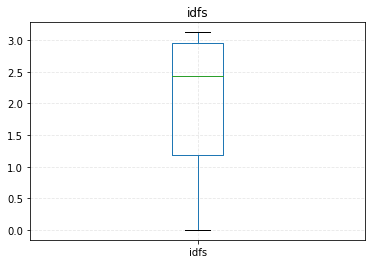

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data = {'idfs': idfs}
df = pd.DataFrame(data)
df.plot.box(title="idfs")
plt.grid(linestyle="--", alpha=0.3)
plt.show()

No handles with labels found to put in legend.


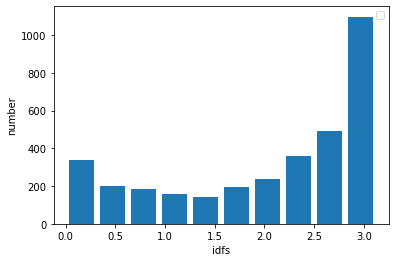

In [8]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


salary = idfs

#group = [0,0.5,1,1.5,2,2.5,3,3.5,4]
group = 10
bottom = [0,5]

plt.hist(salary, group, histtype='bar', rwidth=0.8)

plt.legend()

plt.xlabel('idfs')
plt.ylabel('number')



plt.show()
